# (1) Detect Human

This function takes a path to an image as input & returns "True" if there's a detected face.  The plan is to replace this Python implementation with the iOS implementation [here](https://developer.apple.com/documentation/vision/vndetectfacerectanglesrequest).

### notes on iOS

- Seems straightforward to use the documentation to accomplish this functionality! 

In [1]:
def face_detector(img_path):
    """ returns "True" if face is detected in image stored at img_path """
    import cv2
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

# (2) Detect Dog

The ResNet-50 model takes a pre-processed image as input and outputs the probability that the image contains an object from each of the 1000 categories here.

The `path_to_tensor` function preprocesses the image.  In Python/Keras, this is a necessary step before the model will accept the image.

The `dog_detector` function takes the preprocessed image as input.  It then supplies the pre-processed image to ResNet-50, which returns a (probability) vector with 1000 entries (where the $i$-th entry in the vector is a number between 0 and 1 that yields the probability that the image depicts the $i$-th object category).  The categories that are different dog types should correspond to entries 151-268 in the vector, inclusive.

### notes on iOS

- We need to preprocess the image:
    - Subtract a fixed pixel from every pixel in the image.  If the pixel is expressed in RGB, with red, green, and blue intensities taking on values $[0,255]$, then we need to subtract $[103.939, 116.779, 123.68]$ from every pixel.
    - Convert the image from RGB to BGR.
    - Resize image to 224 x 224 (In Keras, the image needs to be reshaped to a tensor with dimensions `1 x 224 x 224 x 3`, before ResNet-50 will accept the image.  Here, `3` corresponds to the number of color channels (BGR) ... But it looks like for iOS, the image just needs to be a color image that's 224 x 224.)
- In my understanding, the Core ML-compatible ResNet-50 model that is supplied **in the documentation** should return a 1000-dimensional probability vector.  In this case, the dog detector function should be straightforward to implement:
    - We need only take the arg max of that probability vector, which yields the predicted object category (... the arg max will be a value between 0 and 999, inclusive).  
    - The image is deemed by the model to contain a dog if the arg max lies between 151 and 268, inclusive.  Here's the full list of categories: [link](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

In [2]:
def path_to_tensor(img_path):
    """ preprocessing - resize the image, subtract mean pixel, change dimensionality of input """
    from keras.preprocessing import image   
    import numpy as np
    from keras.applications.resnet50 import preprocess_input
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return preprocess_input(x)

def dog_detector(proc_tensor):
    """ returns "True" if a dog is detected in the image stored at img_path """
    from keras.applications.resnet50 import preprocess_input, ResNet50
    import numpy as np
    ResNet50_model = ResNet50(weights='imagenet')
    prediction = np.argmax(ResNet50_model.predict(proc_tensor))
    return ((prediction <= 268) & (prediction >= 151))

# (3) Get Breed

It will take some extra effort to make the student model work (we should talk about this by video, I think).  For now, I think that the best bet is to get a pipeline working that uses just the ResNet-50 model for predicting dog breed.  This model already exists in the iOS documentation ...

The idea would be:
- if a human is detected in Step 1, return the dog that it is predicted to look most like.  
- if a dog is detected in Step 2, return the corresponding breed of dog

... I think that this first attempt would be easily replaced later with the student's model.

### notes on iOS

For now, I think that it's possible to simply return the most predicted dog breed from the ResNet-50 model that exists in the iOS documentation ...

In [3]:
def ResNet50_model_predict_breed(proc_tensor):
    """ uses the ResNet-50 model from the documentation to predict dog breed """
    from keras.applications.resnet50 import ResNet50, decode_predictions
    ResNet50_model = ResNet50(weights='imagenet')
    return decode_predictions(ResNet50_model.predict(proc_tensor), top=0)[0][0][1]

# Full Pipeline: (1) + (2) + (3) (w/ ResNet-50)

In [4]:
def full_pipeline(img_path):
    # get the tensor that will be used to predict breed
    proc_tensor = path_to_tensor(img_path)
    # print the appropriate statements
    if face_detector(img_path):
        print('hello, human! you vaguely resemble ...')
    elif dog_detector(proc_tensor):
        print('hello, dog! you look like a ...')
    else:
        print('hmm, neither human nor dog! but it reminds me of ...')
    print(ResNet50_model_predict_breed(proc_tensor))

# And that's it!

In [ ]:
full_pipeline('test_images/human.jpg')

In [ ]:
full_pipeline('test_images/dog.jpg')

# Saving the ResNet-50 Model for iOS (as HDF5 file)

In [ ]:
# from keras.applications.resnet50 import ResNet50
# model = ResNet50(weights='imagenet')
# model.save('ResNet50_for_iOS.h5')

# Saving the Student's Model for iOS (as HDF5 file)

In [5]:
from keras.applications.resnet50 import ResNet50
from keras.models import load_model, Model
from keras.layers import GlobalAveragePooling2D, Dropout, Dense

resnet_50_model = ResNet50(weights='imagenet', include_top=False)
last = resnet_50_model.output

x = GlobalAveragePooling2D()(last)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
preds = Dense(133, activation='softmax')(x)

student_model = Model(resnet_50_model.input, preds)

# print layers in student_model
print('layers in student_model')
for layer in student_model.layers[-4:]:
    print(layer)

# print layers in student_model_stump
print('\n layers in student_model_stump')
student_model_stump = load_model('student_model_stump.h5')
for layer in student_model_stump.layers:
    print(layer)
    
student_model_stump.summary()

Using TensorFlow backend.


layers in student_model

 layers in student_model_stump
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 1,117,317
Trainable params: 1,117,317
Non-trainable params: 0
_________________________________________________________________


In [6]:
student_model.layers[-4].set_weights(student_model_stump.layers[0].get_weights())
student_model.layers[-3].set_weights(student_model_stump.layers[1].get_weights())
student_model.layers[-2].set_weights(student_model_stump.layers[2].get_weights())
student_model.layers[-1].set_weights(student_model_stump.layers[3].get_weights())

In [7]:
student_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# student_model.save('student_model_for_iOS.h5')

# Full Pipeline: (1) + (2) + (3) (w/ student model)

In [ ]:
# for writing dog names into txt file
'''
from glob import glob
dog_names = [item[58:-1] for item in sorted(glob("../../CNN content/dog-project-private/dogImages/train/*/"))]
print(dog_names)

thefile = open('dog_names.txt', 'w')
for item in dog_names:
    thefile.write("%s\n" % item)
'''

In [23]:
from keras.models import load_model

student_model = load_model('student_model_for_iOS.h5')
text_file = open('dog_names.txt', 'r')
dog_names = text_file.read().split('\n')

def student_model_predict_breed(proc_tensor):
    """ uses the student's model to predict dog breed """
    import numpy as np
    return dog_names[np.argmax(student_model.predict(proc_tensor))]

In [13]:
def full_pipeline_student(img_path):
    # get the tensor that will be used to predict breed
    proc_tensor = path_to_tensor(img_path)
    # print the appropriate statements
    if face_detector(img_path):
        print('hello, human! you vaguely resemble ...')
    elif dog_detector(proc_tensor):
        print('hello, dog! you look like a ...')
    else:
        print('hmm, neither human nor dog! but it reminds me of ...')
    print(student_model_predict_breed(proc_tensor))

In [ ]:
full_pipeline_student('test_images/human.jpg')

In [ ]:
full_pipeline_student('test_images/dog.jpg')

# Testing!!! (not using yet)

In [16]:
def test_them_both(img_path):
    import cv2
    import matplotlib.pyplot as plt
    %matplotlib inline
    print('-'*30)
    plt.imshow(cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (224, 224)))
    plt.show()
    print('STUDENT MODEL!')
    full_pipeline_student(img_path)
    print('RESNET-50 MODEL!')
    full_pipeline(img_path)
    
'''
from glob import glob
files = glob("images/*")
for file in files:
    test_them_both(file)
'''

'\nfrom glob import glob\nfiles = glob("images/*")\nfor file in files:\n    test_them_both(file)\n'

# Returning top 5 probabilities from ResNet-50

In [20]:
from keras.applications.resnet50 import ResNet50, decode_predictions
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

ResNet50_model = ResNet50(weights='imagenet')

def test_resnet_50(img_path):
    proc_tensor = path_to_tensor(img_path)
    print('-'*30)
    plt.imshow(cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (224, 224)))
    plt.show()
    print(decode_predictions(ResNet50_model.predict(proc_tensor), top=5))

------------------------------


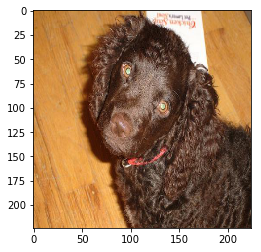

[[('n02102973', 'Irish_water_spaniel', 0.98793507), ('n02099429', 'curly-coated_retriever', 0.0070064571), ('n02113712', 'miniature_poodle', 0.0024928765), ('n02102318', 'cocker_spaniel', 0.00093998166), ('n02113799', 'standard_poodle', 0.00083677162)]]
------------------------------


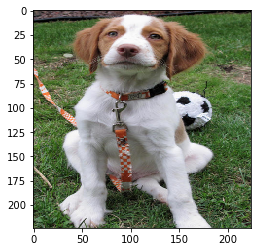

[[('n02101388', 'Brittany_spaniel', 0.99966347), ('n02088364', 'beagle', 0.00016325321), ('n02100583', 'vizsla', 2.4082605e-05), ('n02099712', 'Labrador_retriever', 1.6729791e-05), ('n02102040', 'English_springer', 1.4847804e-05)]]
------------------------------


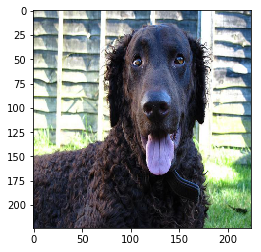

[[('n02099429', 'curly-coated_retriever', 0.96569967), ('n02102973', 'Irish_water_spaniel', 0.017693598), ('n02113799', 'standard_poodle', 0.013769056), ('n02093859', 'Kerry_blue_terrier', 0.00068347965), ('n02099267', 'flat-coated_retriever', 0.00063487928)]]
------------------------------


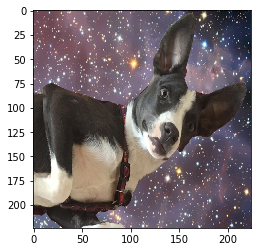

[[('n02096585', 'Boston_bull', 0.98064399), ('n02113186', 'Cardigan', 0.0083804801), ('n02110806', 'basenji', 0.0067106523), ('n02108915', 'French_bulldog', 0.0017723491), ('n02107574', 'Greater_Swiss_Mountain_dog', 0.00067690632)]]
------------------------------


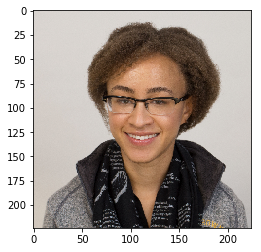

[[('n04325704', 'stole', 0.21449691), ('n03992509', "potter's_wheel", 0.041528285), ('n03617480', 'kimono', 0.035027534), ('n02963159', 'cardigan', 0.033523791), ('n03877472', 'pajama', 0.029713873)]]
------------------------------


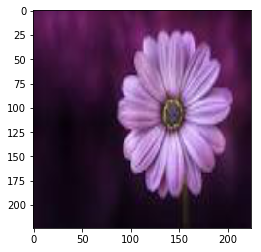

[[('n11939491', 'daisy', 0.35400575), ('n02840245', 'binder', 0.19625373), ('n03476684', 'hair_slide', 0.11911625), ('n04254120', 'soap_dispenser', 0.058113441), ('n04525038', 'velvet', 0.036307272)]]
------------------------------


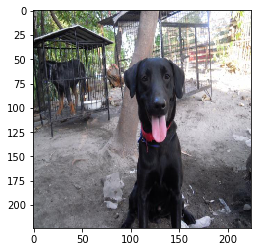

[[('n02099267', 'flat-coated_retriever', 0.49023849), ('n02099712', 'Labrador_retriever', 0.35611501), ('n02109047', 'Great_Dane', 0.090983942), ('n02097130', 'giant_schnauzer', 0.011646822), ('n02099429', 'curly-coated_retriever', 0.010457214)]]
------------------------------


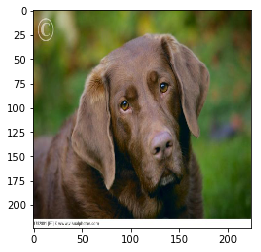

[[('n02099849', 'Chesapeake_Bay_retriever', 0.53323305), ('n02099712', 'Labrador_retriever', 0.26721865), ('n02100583', 'vizsla', 0.094651051), ('n02100236', 'German_short-haired_pointer', 0.036980048), ('n02092339', 'Weimaraner', 0.034266315)]]
------------------------------


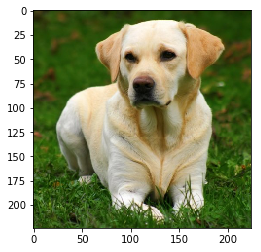

[[('n02099712', 'Labrador_retriever', 0.98081309), ('n02099601', 'golden_retriever', 0.0049550608), ('n04409515', 'tennis_ball', 0.0013648637), ('n02087394', 'Rhodesian_ridgeback', 0.0009463919), ('n02108422', 'bull_mastiff', 0.00094423094)]]
------------------------------


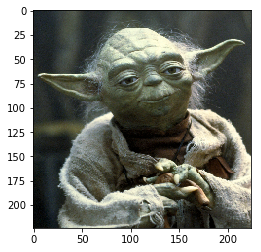

[[('n02481823', 'chimpanzee', 0.28501579), ('n02480855', 'gorilla', 0.1623611), ('n02480495', 'orangutan', 0.07487566), ('n02497673', 'Madagascar_cat', 0.026830131), ('n02483708', 'siamang', 0.024496326)]]
------------------------------


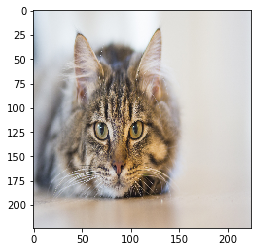

[[('n02123045', 'tabby', 0.50167412), ('n02123159', 'tiger_cat', 0.38876775), ('n02127052', 'lynx', 0.072778955), ('n02124075', 'Egyptian_cat', 0.0074156625), ('n04589890', 'window_screen', 0.0030202279)]]
------------------------------


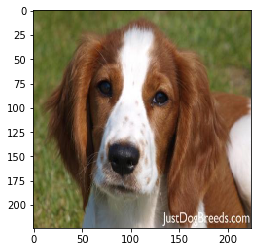

[[('n02102177', 'Welsh_springer_spaniel', 0.97851366), ('n02100877', 'Irish_setter', 0.008581358), ('n02100735', 'English_setter', 0.0030618499), ('n02088238', 'basset', 0.0026601027), ('n02101388', 'Brittany_spaniel', 0.0017649101)]]


In [21]:
from glob import glob
files = glob("images/*")
for file in files:
    test_resnet_50(file)

# Returning most likely label in student model

------------------------------


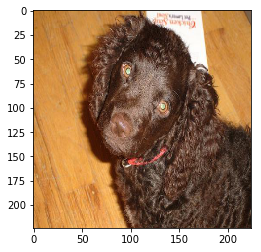

hello, dog! you look like a ...
Curly-coated_retriever
------------------------------


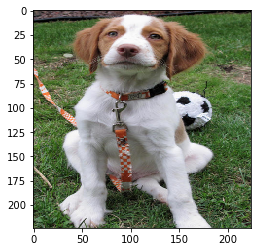

hello, dog! you look like a ...
Brittany
------------------------------


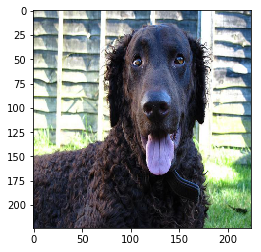

hello, dog! you look like a ...
Curly-coated_retriever
------------------------------


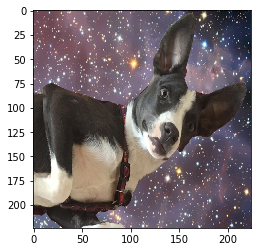

hello, dog! you look like a ...
Boston_terrier
------------------------------


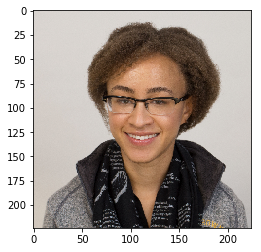

hello, human! you vaguely resemble ...
Kerry_blue_terrier
------------------------------


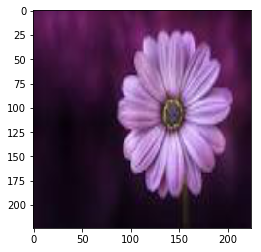

hmm, neither human nor dog! but it reminds me of ...
Chinese_crested
------------------------------


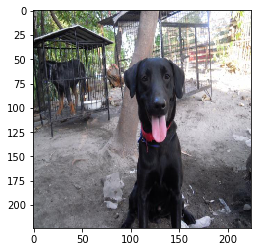

hello, dog! you look like a ...
Labrador_retriever
------------------------------


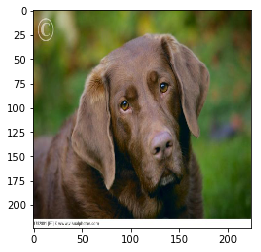

hello, dog! you look like a ...
Labrador_retriever
------------------------------


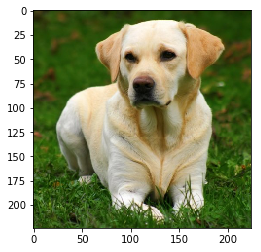

hello, dog! you look like a ...
Labrador_retriever
------------------------------


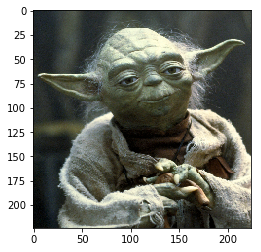

hello, human! you vaguely resemble ...
Xoloitzcuintli
------------------------------


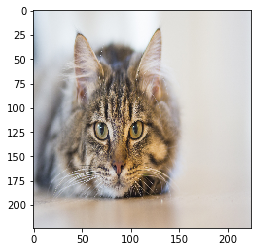

hmm, neither human nor dog! but it reminds me of ...
Brussels_griffon
------------------------------


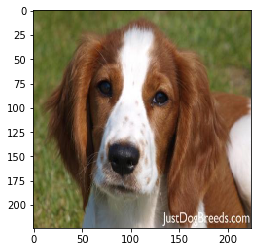

hello, dog! you look like a ...
Welsh_springer_spaniel


In [24]:
def test_student_model(img_path):
    print('-'*30)
    plt.imshow(cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (224, 224)))
    plt.show()
    full_pipeline_student(img_path)
    
from glob import glob
files = glob("images/*")
for file in files:
    test_student_model(file)